# Unemployment Rate Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import random
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

#import statsmodels as sm
#import statsmodels.api as smt
#from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import tensorflow as tf

np.random.seed(1) 
tf.random.set_seed(1) 
random.seed(1)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,5

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


# **Import, preprocess the data and perform EDA**

In [2]:
# Import data

dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
data = pd.read_csv('UnemploymentRateJan1986-Dec2018.csv', 
                   parse_dates=['Months'], 
                   index_col='Months',
                   date_parser=dateparse)

ts_all = data['Unemployment_Rates']

In [3]:
ts_all.head()

Months
1986-01-01    8.53
1986-02-01    8.92
1986-03-01    8.48
1986-04-01    8.06
1986-05-01    7.71
Name: Unemployment_Rates, dtype: float64

In [4]:
# Check how many value in time series

len(ts_all)

396

In [5]:
# Descriptive stats for unemployment rate

ts_all.describe()

count    396.000000
mean       6.726212
std        1.811832
min        3.930000
25%        5.410000
50%        6.210000
75%        7.947500
max       11.990000
Name: Unemployment_Rates, dtype: float64

In [6]:
# Check is there any missing value in time series

if data.isnull().values.any():
    print("Having missing values")
else:
   print("No missing values")

No missing values


### **Original data plot**

Text(0, 0.5, 'Unemployment Rate (%)')

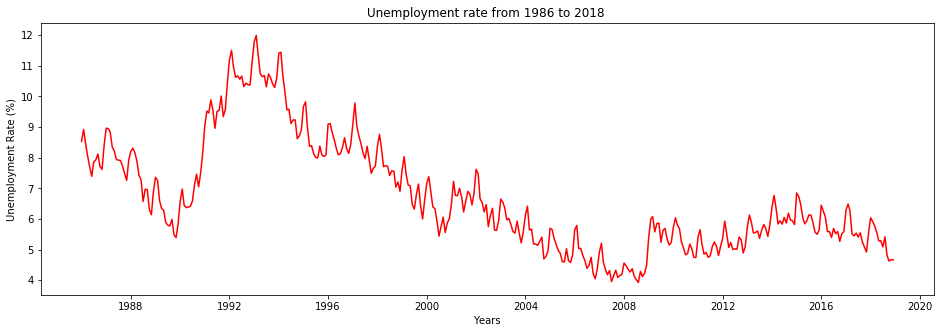

In [7]:
plt.figure(figsize=(16, 5)) 
plt.plot(ts_all,'r-') 
plt.title('Unemployment rate from 1986 to 2018 ') 
plt.xlabel('Years') 
plt.ylabel('Unemployment Rate (%)')

### **Seasonal plot**

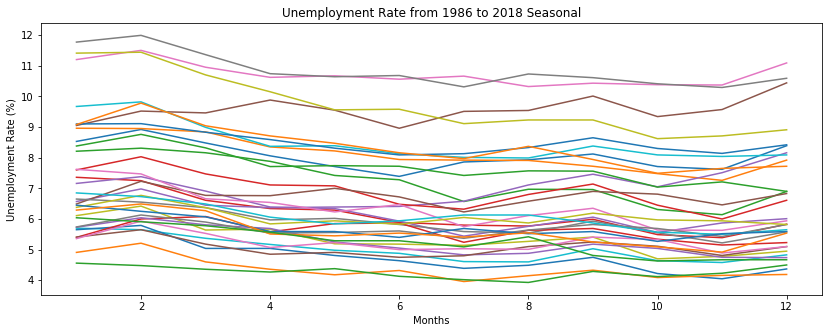

In [8]:
seasonal = ts_all.copy()
seasonal.index = seasonal.index.month

plt.figure(figsize=(14, 5))

for i in range(int(len(seasonal)/12)): # Use len * 12
    plt.plot(seasonal[0+12*i : 12+12*i]) # Every cycle one plot # Assume seasonal peroid is 12 evey 12 month one cycle

plt.title('Unemployment Rate from 1986 to 2018 Seasonal')
plt.xlabel('Months')
plt.ylabel('Unemployment Rate (%)')
plt.show()

Text(0, 0.5, 'Unemployment Rate (%)')

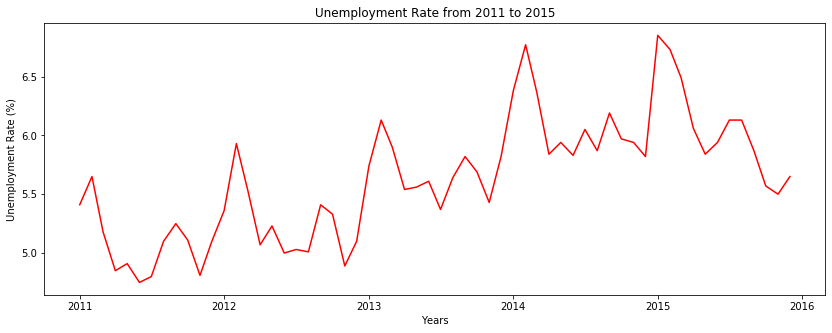

In [9]:
# Plot the filtered period for looking the pattern of time series

ts_2011_2015 = ts_all['2011':'2015']

plt.figure(figsize=(14, 5)) 
plt.plot(ts_2011_2015,'r-') 
plt.title('Unemployment Rate from 2011 to 2015') 
plt.xlabel('Years') 
plt.ylabel('Unemployment Rate (%)')  


# From the graph in year 2011 and 2015, it could be seen that
# January and February has high unemployment rate each year
# In April to June has low unemployment rate

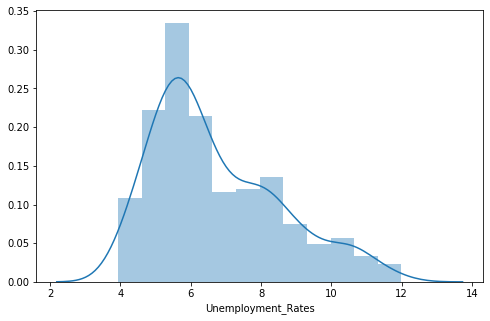

In [10]:
# Check data distribution

plt.figure(figsize=(8, 5)) 

sns.distplot(ts_all)

### **Stationary**

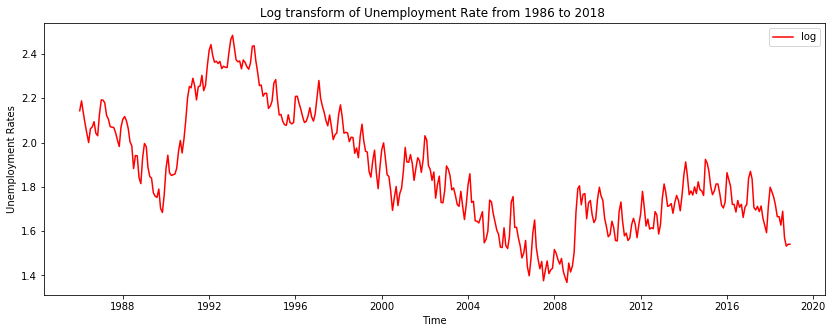

In [11]:
# Check stationary of time series after using log transformation

ts_log= np.log(ts_all)
plt.figure(figsize=(14, 5)) 
plt.plot(ts_log, color='red',label='log')
plt.title('Log transform of Unemployment Rate from 1986 to 2018 ') 
plt.xlabel('Time')
plt.ylabel('Unemployment Rates')
plt.legend()

In [12]:
# ADF test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts_log)
print("--------------")
test_stationarity(ts_all)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.809907
p-value                          0.375555
#Lags Used                      16.000000
Number of Observations Used    379.000000
Critical Value (1%)             -3.447722
Critical Value (5%)             -2.869196
Critical Value (10%)            -2.570849
dtype: float64
--------------
Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.862546
p-value                          0.349880
#Lags Used                      17.000000
Number of Observations Used    378.000000
Critical Value (1%)             -3.447769
Critical Value (5%)             -2.869217
Critical Value (10%)            -2.570860
dtype: float64


# **Split Train-Test Dataset**

In [13]:
# Use data from 1986 to 2017 as train data
# Use data in 2018 as test data

size_test = 12
size_train = len(ts_all) - size_test

ts_train = ts_all[ : size_train]
ts_test = ts_all[ -size_test:] # Last 12 data which is Jan to Dec in 2018

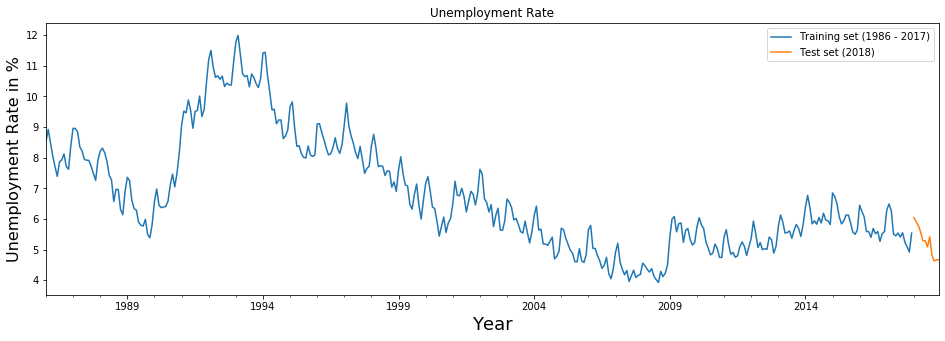

In [14]:
ts_train.plot(figsize=(16,5),legend=True)
ts_test.plot(figsize=(16,5),legend=True)
plt.legend(['Training set (1986 - 2017)','Test set (2018)'])
plt.title('Unemployment Rate')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Unemployment Rate in %', fontsize=16)
plt.show()

### **Define MSE function for calculating MSE value**

In [15]:
def mse(x, y):
    return np.mean(np.power(x - y,2))

### **Apply decomposition function**

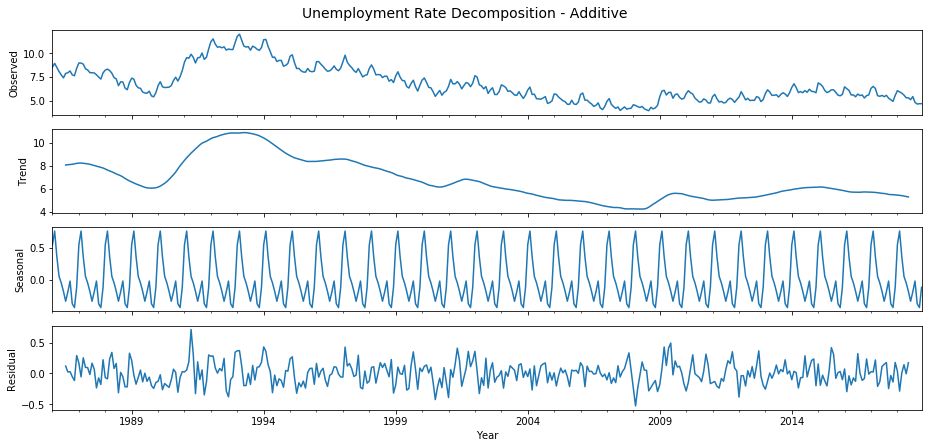

In [16]:
# Use decomposition function with addtitive method to see trend and seasonality pattern

decompose_result = seasonal_decompose(ts_all, model='additive')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True)
 
decompose_result.observed.plot(figsize=(13,6), ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decompose_result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decompose_result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decompose_result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

plt.suptitle('Unemployment Rate Decomposition - Additive', y=1.03, fontsize=14)
plt.xlabel('Year')
plt.tight_layout()
plt.show()

# **Forecast unemployment rate in 2018 ahead using Holt-Winter's Method**


### **Train Holt-Winters' Method Model**

In [17]:
start_time = time.time()

ts_train_hw = ts_train.copy()


# Find optimal alpha, beta, gamma and damped that get lowest mse value
# Training and forecasting take about 5 minutes

ii = 0

for alpha in np.arange(0.1, 0.9, 0.1):
    for beta in np.arange(0.1, 0.9, 0.1):
        for gamma in np.arange(0.1, 0.9, 0.1):
            for damped in np.arange(0.8, 1.0, 0.02):

                
                
# Train the Holt-Winter's model 
                hw_model = ExponentialSmoothing(ts_train_hw, seasonal_periods=12, 
                                 trend='add', seasonal='add', 
                                 damped=True).fit(smoothing_level = alpha,
                                                                  smoothing_slope = beta,
                                                                  smoothing_seasonal = gamma,
                                                                  damping_slope = damped)   

                                                       

# Forecast for next 12-step ahead and find mse value                                                                                                                               
                hw_fcast = hw_model.forecast(12)
                hw_current_mse = mse(hw_fcast, ts_test)

# Store the value of first running loop
                if ii == 0:                                                              
                    hw_min_mse = mse(hw_fcast, ts_test)
                    optimal_hw_alpha = alpha
                    optimal_hw_beta = beta
                    optimal_hw_gamma = gamma
                    optimal_hw_damped = damped
                    optimal_hw_model = hw_model
                    optimal_hw_fcast = hw_fcast
                    ii +=1


# Check if new mse value is lower than the min_mse value or not
                if hw_current_mse < hw_min_mse:
                    hw_min_mse = hw_current_mse
                    optimal_hw_alpha = alpha
                    optimal_hw_beta = beta
                    optimal_hw_gamma = gamma
                    optimal_hw_damped = damped
                    optimal_hw_model = hw_model
                    optimal_hw_fcast = hw_fcast


# Print the total training and test time
time_hw = time.time() - start_time
print("--- %s seconds ---" % (time_hw))

--- 195.5699381828308 seconds ---


### **Plot the prediction result on train data from optimal hyperparameter**

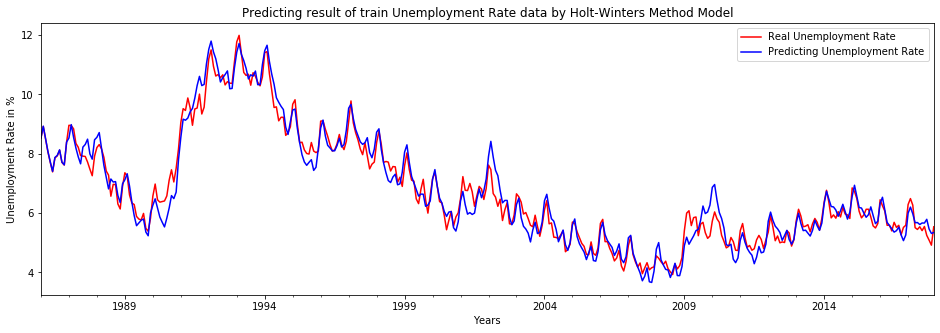

In [18]:
plt.figure(figsize=(16,5))
ts_train_hw.plot(color='red', legend=True)
optimal_hw_model.fittedvalues.plot(color='blue', legend=True)
plt.legend(['Real Unemployment Rate', 'Predicting Unemployment Rate'])
plt.title('Predicting result of train Unemployment Rate data by Holt-Winters Method Model')
plt.xlabel('Years')
plt.ylabel('Unemployment Rate in %')
plt.show()   

### **Plot graph between test data and forecasting of Holt-Winters' Method Model**

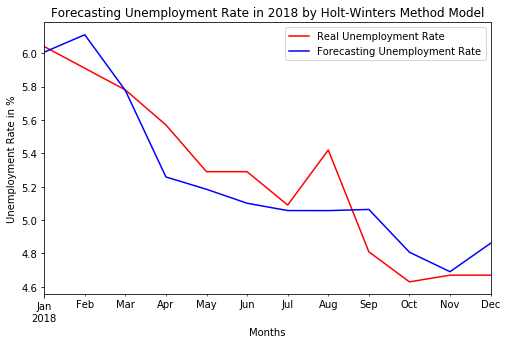

In [19]:
plt.figure(figsize=(8,5))
ts_test.plot(color='red', legend=True)
optimal_hw_fcast.plot(color='blue', legend=True)
plt.legend(['Real Unemployment Rate', 'Forecasting Unemployment Rate'])
plt.title('Forecasting Unemployment Rate in 2018 by Holt-Winters Method Model')
plt.ylabel('Unemployment Rate in %')
plt.show()

### **Calculate MSE value with optimal hyperparameter**

In [20]:
print("Optimal value of alpha is:", optimal_hw_alpha)
print("Optimal value of beta is:", optimal_hw_beta)
print("Optimal value of gamma is:", optimal_hw_gamma)
print("Optimal value of damped is: {0:.3F}".format(optimal_hw_damped))
print("The lowest MSE value of Holt-Winters' method model is: {0:.3F}".format(hw_min_mse))                  

Optimal value of alpha is: 0.1
Optimal value of beta is: 0.5
Optimal value of gamma is: 0.2
Optimal value of damped is: 0.980
The lowest MSE value of Holt-Winters' method model is: 0.038


# **Forecast unemployment rate in 2018 using LSTM (Deep Learning) Method**

### **Prepare the data for train and test the model**

In [21]:
# Preparing the data

# Split train and test set
ts_train_lstm = ts_train.copy()
ts_train_lstm = ts_train_lstm.values
ts_test_lstm = ts_test.copy()
ts_test_lstm = ts_test_lstm.values


# Data pre-processing

# Scaling the training set
ts_train_lstm = ts_train_lstm.reshape(-1, 1)
sc_lstm = MinMaxScaler(feature_range=(0,1))
training_set_scaled_lstm = sc_lstm.fit_transform(ts_train_lstm)



# Prepare training data by using 12 history timesteps for training 
# and predict 1-step ahead output to use in LSTM model.

X_train_lstm = []
y_train_lstm = []

lookback_step = 12

for i in range(lookback_step, len(ts_all) - 12):
    X_train_lstm.append(training_set_scaled_lstm[i-lookback_step : i, 0])
    y_train_lstm.append(training_set_scaled_lstm[i, 0])
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)


# Reshaping X_train for training by using LSTM model
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))


In [22]:
# Prepare test data by using 12 previous timesteps to predict 1-step ahead
dataset_total_lstm = ts_all.copy()
inputs_lstm = dataset_total_lstm[len(dataset_total_lstm)-len(ts_test_lstm) - lookback_step : ].values
inputs_lstm = inputs_lstm.reshape(-1, 1)
inputs_lstm = sc_lstm.transform(inputs_lstm)


# Preparing X_test
X_test_lstm = []
for i in range(lookback_step, lookback_step + 12):
    X_test_lstm.append(inputs_lstm[i-lookback_step:i, 0])
X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [23]:
# Train the model with tuning hyperparameter and find optimal hyperparameter to get best MSE result.
# Hyperparameter: neurons, batch size and dropout

start_time = time.time()

ii = 0


lstm_neurons = [5, 10, 15]
lstm_batch_size = [6, 12, 24]
lstm_dropout = [0.05, 0.1, 0.2]

for neurons in range(len(lstm_neurons)):
    for batch_size in range(len(lstm_batch_size)):
        for dropout in range(len(lstm_dropout)):

            # Create neural network layers
            model_lstm = Sequential()
    
            # LSTM layer with Dropout regularisation
            model_lstm.add(LSTM(units=lstm_neurons[neurons], return_sequences=False, 
                                input_shape=(X_train_lstm.shape[1],1), activation = 'relu'))
            model_lstm.add(Dropout(lstm_dropout[dropout]))
    
            # The output layer
            model_lstm.add(Dense(output_dim = 1))
            model_lstm.add(Activation('linear'))

            # Compiling the neural network
            model_lstm.compile(optimizer='adam',loss='mse')
    
            # Training the model
            model_lstm.fit(X_train_lstm, y_train_lstm, epochs=200, 
                           validation_split = 0.1, batch_size=lstm_batch_size[batch_size])

            # Forecast next 12-step ahead and find mse value                                                                                                                               
            fcast_lstm = model_lstm.predict(X_test_lstm)
            fcast_lstm = sc_lstm.inverse_transform(fcast_lstm)
            fcast_lstm = fcast_lstm.flatten()
            current_mse_lstm = mse(fcast_lstm, ts_test)

    # Store the value of first running loop
            if ii == 0:                                                              
                optimal_lstm_neurons = lstm_neurons[0]
                optimal_lstm_batch_size = lstm_batch_size[batch_size]
                optimal_lstm_dropout = lstm_dropout[0]
                optimal_lstm_model = model_lstm
                optimal_lstm_fcast = fcast_lstm
                min_mse_lstm = mse(fcast_lstm, ts_test)
                ii +=1

    # Check if new mse value is lower than the min_mse value or not
            if current_mse_lstm < min_mse_lstm:
                min_mse_lstm = current_mse_lstm
                optimal_lstm_neurons = lstm_neurons[neurons]
                optimal_lstm_batch_size = lstm_batch_size[batch_size]
                optimal_lstm_dropout = lstm_dropout[dropout]
                optimal_lstm_model = model_lstm
                optimal_lstm_fcast = fcast_lstm


# Print the total training and test time
time_lstm = time.time() - start_time
print("--- %s seconds ---" % (time_lstm))

Train on 334 samples, validate on 38 samples
Epoch 1/200
334/334 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0024
Epoch 2/200
334/334 [==============================] - 0s 720us/step - loss: 0.0124 - val_loss: 0.0023
Epoch 3/200
334/334 [==============================] - 0s 749us/step - loss: 0.0113 - val_loss: 0.0023
Epoch 4/200
334/334 [==============================] - 0s 741us/step - loss: 0.0107 - val_loss: 0.0023
Epoch 5/200
334/334 [==============================] - 0s 732us/step - loss: 0.0109 - val_loss: 0.0024
Epoch 6/200
334/334 [==============================] - 0s 738us/step - loss: 0.0085 - val_loss: 0.0023
Epoch 7/200
334/334 [==============================] - 0s 749us/step - loss: 0.0099 - val_loss: 0.0025
Epoch 8/200
334/334 [==============================] - 0s 741us/step - loss: 0.0083 - val_loss: 0.0023
Epoch 9/200
334/334 [==============================] - 0s 741us/step - loss: 0.0086 - val_loss: 0.0023
Epoch 10/200
334/334 [========

334/334 [==============================] - 0s 749us/step - loss: 0.0051 - val_loss: 0.0020
Epoch 80/200
334/334 [==============================] - 0s 735us/step - loss: 0.0054 - val_loss: 0.0021
Epoch 81/200
334/334 [==============================] - 0s 732us/step - loss: 0.0065 - val_loss: 0.0021
Epoch 82/200
334/334 [==============================] - 0s 735us/step - loss: 0.0062 - val_loss: 0.0025
Epoch 83/200
334/334 [==============================] - 0s 735us/step - loss: 0.0058 - val_loss: 0.0020
Epoch 84/200
334/334 [==============================] - 0s 726us/step - loss: 0.0058 - val_loss: 0.0020
Epoch 85/200
334/334 [==============================] - 0s 732us/step - loss: 0.0050 - val_loss: 0.0021
Epoch 86/200
334/334 [==============================] - 0s 714us/step - loss: 0.0060 - val_loss: 0.0021
Epoch 87/200
334/334 [==============================] - 0s 732us/step - loss: 0.0076 - val_loss: 0.0020
Epoch 88/200
334/334 [==============================] - 0s 735us/step - loss:

334/334 [==============================] - 0s 744us/step - loss: 0.0048 - val_loss: 0.0019
Epoch 158/200
334/334 [==============================] - 0s 738us/step - loss: 0.0059 - val_loss: 0.0020
Epoch 159/200
334/334 [==============================] - 0s 729us/step - loss: 0.0046 - val_loss: 0.0020
Epoch 160/200
334/334 [==============================] - 0s 735us/step - loss: 0.0072 - val_loss: 0.0019
Epoch 161/200
334/334 [==============================] - 0s 738us/step - loss: 0.0060 - val_loss: 0.0018
Epoch 162/200
334/334 [==============================] - 0s 732us/step - loss: 0.0047 - val_loss: 0.0019
Epoch 163/200
334/334 [==============================] - 0s 738us/step - loss: 0.0054 - val_loss: 0.0018
Epoch 164/200
334/334 [==============================] - 0s 735us/step - loss: 0.0059 - val_loss: 0.0018
Epoch 165/200
334/334 [==============================] - 0s 809us/step - loss: 0.0053 - val_loss: 0.0018
Epoch 166/200
334/334 [==============================] - 0s 717us/ste

334/334 [==============================] - 0s 833us/step - loss: 0.0099 - val_loss: 0.0024
Epoch 36/200
334/334 [==============================] - 0s 908us/step - loss: 0.0082 - val_loss: 0.0025
Epoch 37/200
334/334 [==============================] - 0s 854us/step - loss: 0.0090 - val_loss: 0.0024
Epoch 38/200
334/334 [==============================] - 0s 732us/step - loss: 0.0108 - val_loss: 0.0024
Epoch 39/200
334/334 [==============================] - 0s 752us/step - loss: 0.0100 - val_loss: 0.0024
Epoch 40/200
334/334 [==============================] - 0s 738us/step - loss: 0.0101 - val_loss: 0.0024
Epoch 41/200
334/334 [==============================] - 0s 890us/step - loss: 0.0130 - val_loss: 0.0024
Epoch 42/200
334/334 [==============================] - 0s 758us/step - loss: 0.0098 - val_loss: 0.0025
Epoch 43/200
334/334 [==============================] - 0s 764us/step - loss: 0.0117 - val_loss: 0.0024
Epoch 44/200
334/334 [==============================] - 0s 732us/step - loss:

334/334 [==============================] - 0s 752us/step - loss: 0.0090 - val_loss: 0.0028
Epoch 114/200
334/334 [==============================] - 0s 738us/step - loss: 0.0074 - val_loss: 0.0026
Epoch 115/200
334/334 [==============================] - 0s 744us/step - loss: 0.0080 - val_loss: 0.0025
Epoch 116/200
334/334 [==============================] - 0s 723us/step - loss: 0.0080 - val_loss: 0.0022
Epoch 117/200
334/334 [==============================] - 0s 729us/step - loss: 0.0080 - val_loss: 0.0029
Epoch 118/200
334/334 [==============================] - 0s 729us/step - loss: 0.0103 - val_loss: 0.0026
Epoch 119/200
334/334 [==============================] - 0s 735us/step - loss: 0.0071 - val_loss: 0.0024
Epoch 120/200
334/334 [==============================] - 0s 729us/step - loss: 0.0087 - val_loss: 0.0024
Epoch 121/200
334/334 [==============================] - 0s 729us/step - loss: 0.0095 - val_loss: 0.0025
Epoch 122/200
334/334 [==============================] - 0s 735us/ste

334/334 [==============================] - 0s 758us/step - loss: 0.0093 - val_loss: 0.0025
Epoch 192/200
334/334 [==============================] - 0s 741us/step - loss: 0.0085 - val_loss: 0.0024
Epoch 193/200
334/334 [==============================] - 0s 741us/step - loss: 0.0107 - val_loss: 0.0026
Epoch 194/200
334/334 [==============================] - 0s 747us/step - loss: 0.0078 - val_loss: 0.0026
Epoch 195/200
334/334 [==============================] - 0s 755us/step - loss: 0.0088 - val_loss: 0.0022
Epoch 196/200
334/334 [==============================] - 0s 735us/step - loss: 0.0092 - val_loss: 0.0023
Epoch 197/200
334/334 [==============================] - 0s 738us/step - loss: 0.0059 - val_loss: 0.0023
Epoch 198/200
334/334 [==============================] - 0s 744us/step - loss: 0.0081 - val_loss: 0.0022
Epoch 199/200
334/334 [==============================] - 0s 755us/step - loss: 0.0100 - val_loss: 0.0024
Epoch 200/200
334/334 [==============================] - 0s 749us/ste

334/334 [==============================] - 0s 875us/step - loss: 0.0136 - val_loss: 0.0038
Epoch 70/200
334/334 [==============================] - 0s 878us/step - loss: 0.0136 - val_loss: 0.0036
Epoch 71/200
334/334 [==============================] - 0s 842us/step - loss: 0.0134 - val_loss: 0.0039
Epoch 72/200
334/334 [==============================] - 0s 747us/step - loss: 0.0135 - val_loss: 0.0035
Epoch 73/200
334/334 [==============================] - 0s 723us/step - loss: 0.0112 - val_loss: 0.0030
Epoch 74/200
334/334 [==============================] - 0s 738us/step - loss: 0.0126 - val_loss: 0.0034
Epoch 75/200
334/334 [==============================] - 0s 738us/step - loss: 0.0117 - val_loss: 0.0036
Epoch 76/200
334/334 [==============================] - 0s 744us/step - loss: 0.0108 - val_loss: 0.0038
Epoch 77/200
334/334 [==============================] - 0s 735us/step - loss: 0.0111 - val_loss: 0.0030
Epoch 78/200
334/334 [==============================] - 0s 752us/step - loss:

334/334 [==============================] - 0s 749us/step - loss: 0.0139 - val_loss: 0.0028
Epoch 148/200
334/334 [==============================] - 0s 738us/step - loss: 0.0104 - val_loss: 0.0028
Epoch 149/200
334/334 [==============================] - 0s 755us/step - loss: 0.0104 - val_loss: 0.0027
Epoch 150/200
334/334 [==============================] - 0s 747us/step - loss: 0.0110 - val_loss: 0.0024
Epoch 151/200
334/334 [==============================] - 0s 735us/step - loss: 0.0112 - val_loss: 0.0030
Epoch 152/200
334/334 [==============================] - 0s 761us/step - loss: 0.0112 - val_loss: 0.0032
Epoch 153/200
334/334 [==============================] - 0s 749us/step - loss: 0.0105 - val_loss: 0.0027
Epoch 154/200
334/334 [==============================] - 0s 741us/step - loss: 0.0131 - val_loss: 0.0028
Epoch 155/200
334/334 [==============================] - 0s 752us/step - loss: 0.0120 - val_loss: 0.0026
Epoch 156/200
334/334 [==============================] - 0s 761us/ste

334/334 [==============================] - 0s 370us/step - loss: 0.0078 - val_loss: 0.0022
Epoch 26/200
334/334 [==============================] - 0s 376us/step - loss: 0.0126 - val_loss: 0.0022
Epoch 27/200
334/334 [==============================] - 0s 376us/step - loss: 0.0072 - val_loss: 0.0022
Epoch 28/200
334/334 [==============================] - 0s 376us/step - loss: 0.0073 - val_loss: 0.0023
Epoch 29/200
334/334 [==============================] - 0s 367us/step - loss: 0.0080 - val_loss: 0.0023
Epoch 30/200
334/334 [==============================] - 0s 376us/step - loss: 0.0092 - val_loss: 0.0022
Epoch 31/200
334/334 [==============================] - 0s 373us/step - loss: 0.0066 - val_loss: 0.0022
Epoch 32/200
334/334 [==============================] - 0s 373us/step - loss: 0.0054 - val_loss: 0.0022
Epoch 33/200
334/334 [==============================] - 0s 373us/step - loss: 0.0093 - val_loss: 0.0022
Epoch 34/200
334/334 [==============================] - 0s 373us/step - loss:

Epoch 104/200
334/334 [==============================] - 0s 376us/step - loss: 0.0074 - val_loss: 0.0021
Epoch 105/200
334/334 [==============================] - 0s 370us/step - loss: 0.0077 - val_loss: 0.0021
Epoch 106/200
334/334 [==============================] - 0s 376us/step - loss: 0.0065 - val_loss: 0.0021
Epoch 107/200
334/334 [==============================] - 0s 370us/step - loss: 0.0063 - val_loss: 0.0021
Epoch 108/200
334/334 [==============================] - 0s 376us/step - loss: 0.0087 - val_loss: 0.0021
Epoch 109/200
334/334 [==============================] - 0s 373us/step - loss: 0.0077 - val_loss: 0.0021
Epoch 110/200
334/334 [==============================] - 0s 376us/step - loss: 0.0066 - val_loss: 0.0021
Epoch 111/200
334/334 [==============================] - 0s 370us/step - loss: 0.0066 - val_loss: 0.0021
Epoch 112/200
334/334 [==============================] - 0s 376us/step - loss: 0.0074 - val_loss: 0.0021
Epoch 113/200
334/334 [==============================] 

334/334 [==============================] - 0s 400us/step - loss: 0.0085 - val_loss: 0.0020
Epoch 183/200
334/334 [==============================] - 0s 388us/step - loss: 0.0064 - val_loss: 0.0020
Epoch 184/200
334/334 [==============================] - 0s 379us/step - loss: 0.0068 - val_loss: 0.0021
Epoch 185/200
334/334 [==============================] - 0s 382us/step - loss: 0.0070 - val_loss: 0.0021
Epoch 186/200
334/334 [==============================] - 0s 382us/step - loss: 0.0063 - val_loss: 0.0021
Epoch 187/200
334/334 [==============================] - 0s 379us/step - loss: 0.0057 - val_loss: 0.0021
Epoch 188/200
334/334 [==============================] - 0s 376us/step - loss: 0.0059 - val_loss: 0.0021
Epoch 189/200
334/334 [==============================] - 0s 373us/step - loss: 0.0089 - val_loss: 0.0021
Epoch 190/200
334/334 [==============================] - 0s 379us/step - loss: 0.0058 - val_loss: 0.0020
Epoch 191/200
334/334 [==============================] - 0s 379us/ste

334/334 [==============================] - 0s 400us/step - loss: 0.0105 - val_loss: 0.0025
Epoch 61/200
334/334 [==============================] - 0s 379us/step - loss: 0.0105 - val_loss: 0.0025
Epoch 62/200
334/334 [==============================] - 0s 433us/step - loss: 0.0094 - val_loss: 0.0025
Epoch 63/200
334/334 [==============================] - 0s 397us/step - loss: 0.0105 - val_loss: 0.0027
Epoch 64/200
334/334 [==============================] - 0s 418us/step - loss: 0.0101 - val_loss: 0.0025
Epoch 65/200
334/334 [==============================] - 0s 418us/step - loss: 0.0089 - val_loss: 0.0025
Epoch 66/200
334/334 [==============================] - 0s 379us/step - loss: 0.0118 - val_loss: 0.0028
Epoch 67/200
334/334 [==============================] - 0s 385us/step - loss: 0.0069 - val_loss: 0.0026
Epoch 68/200
334/334 [==============================] - 0s 376us/step - loss: 0.0095 - val_loss: 0.0026
Epoch 69/200
334/334 [==============================] - 0s 376us/step - loss:

334/334 [==============================] - 0s 388us/step - loss: 0.0116 - val_loss: 0.0035
Epoch 139/200
334/334 [==============================] - 0s 391us/step - loss: 0.0078 - val_loss: 0.0030
Epoch 140/200
334/334 [==============================] - 0s 373us/step - loss: 0.0116 - val_loss: 0.0030
Epoch 141/200
334/334 [==============================] - 0s 379us/step - loss: 0.0092 - val_loss: 0.0029
Epoch 142/200
334/334 [==============================] - 0s 376us/step - loss: 0.0114 - val_loss: 0.0031
Epoch 143/200
334/334 [==============================] - 0s 385us/step - loss: 0.0088 - val_loss: 0.0029
Epoch 144/200
334/334 [==============================] - 0s 373us/step - loss: 0.0090 - val_loss: 0.0029
Epoch 145/200
334/334 [==============================] - 0s 379us/step - loss: 0.0080 - val_loss: 0.0034
Epoch 146/200
334/334 [==============================] - 0s 391us/step - loss: 0.0094 - val_loss: 0.0030
Epoch 147/200
334/334 [==============================] - 0s 394us/ste

Epoch 16/200
334/334 [==============================] - 0s 388us/step - loss: 0.0158 - val_loss: 0.0025
Epoch 17/200
334/334 [==============================] - 0s 376us/step - loss: 0.0146 - val_loss: 0.0026
Epoch 18/200
334/334 [==============================] - 0s 373us/step - loss: 0.0186 - val_loss: 0.0025
Epoch 19/200
334/334 [==============================] - 0s 370us/step - loss: 0.0159 - val_loss: 0.0025
Epoch 20/200
334/334 [==============================] - 0s 373us/step - loss: 0.0133 - val_loss: 0.0025
Epoch 21/200
334/334 [==============================] - 0s 364us/step - loss: 0.0167 - val_loss: 0.0025
Epoch 22/200
334/334 [==============================] - 0s 364us/step - loss: 0.0196 - val_loss: 0.0025
Epoch 23/200
334/334 [==============================] - 0s 376us/step - loss: 0.0122 - val_loss: 0.0024
Epoch 24/200
334/334 [==============================] - 0s 367us/step - loss: 0.0140 - val_loss: 0.0025
Epoch 25/200
334/334 [==============================] - 0s 379us

Epoch 95/200
334/334 [==============================] - 0s 391us/step - loss: 0.0117 - val_loss: 0.0027
Epoch 96/200
334/334 [==============================] - 0s 373us/step - loss: 0.0119 - val_loss: 0.0028
Epoch 97/200
334/334 [==============================] - 0s 382us/step - loss: 0.0124 - val_loss: 0.0027
Epoch 98/200
334/334 [==============================] - 0s 379us/step - loss: 0.0132 - val_loss: 0.0027
Epoch 99/200
334/334 [==============================] - 0s 367us/step - loss: 0.0106 - val_loss: 0.0026
Epoch 100/200
334/334 [==============================] - 0s 397us/step - loss: 0.0111 - val_loss: 0.0026
Epoch 101/200
334/334 [==============================] - 0s 415us/step - loss: 0.0127 - val_loss: 0.0028
Epoch 102/200
334/334 [==============================] - 0s 382us/step - loss: 0.0132 - val_loss: 0.0026
Epoch 103/200
334/334 [==============================] - 0s 379us/step - loss: 0.0107 - val_loss: 0.0028
Epoch 104/200
334/334 [==============================] - 0s 

334/334 [==============================] - 0s 385us/step - loss: 0.0110 - val_loss: 0.0026
Epoch 174/200
334/334 [==============================] - 0s 376us/step - loss: 0.0108 - val_loss: 0.0026
Epoch 175/200
334/334 [==============================] - 0s 379us/step - loss: 0.0118 - val_loss: 0.0025
Epoch 176/200
334/334 [==============================] - 0s 373us/step - loss: 0.0104 - val_loss: 0.0026
Epoch 177/200
334/334 [==============================] - 0s 373us/step - loss: 0.0109 - val_loss: 0.0026
Epoch 178/200
334/334 [==============================] - 0s 376us/step - loss: 0.0098 - val_loss: 0.0027
Epoch 179/200
334/334 [==============================] - 0s 376us/step - loss: 0.0106 - val_loss: 0.0026
Epoch 180/200
334/334 [==============================] - 0s 388us/step - loss: 0.0106 - val_loss: 0.0029
Epoch 181/200
334/334 [==============================] - 0s 379us/step - loss: 0.0113 - val_loss: 0.0025
Epoch 182/200
334/334 [==============================] - 0s 373us/ste

334/334 [==============================] - 0s 209us/step - loss: 0.0113 - val_loss: 0.0024
Epoch 52/200
334/334 [==============================] - 0s 200us/step - loss: 0.0107 - val_loss: 0.0024
Epoch 53/200
334/334 [==============================] - 0s 197us/step - loss: 0.0118 - val_loss: 0.0024
Epoch 54/200
334/334 [==============================] - 0s 197us/step - loss: 0.0098 - val_loss: 0.0024
Epoch 55/200
334/334 [==============================] - 0s 191us/step - loss: 0.0073 - val_loss: 0.0024
Epoch 56/200
334/334 [==============================] - 0s 194us/step - loss: 0.0088 - val_loss: 0.0024
Epoch 57/200
334/334 [==============================] - 0s 197us/step - loss: 0.0104 - val_loss: 0.0023
Epoch 58/200
334/334 [==============================] - 0s 188us/step - loss: 0.0128 - val_loss: 0.0023
Epoch 59/200
334/334 [==============================] - 0s 197us/step - loss: 0.0085 - val_loss: 0.0024
Epoch 60/200
334/334 [==============================] - 0s 200us/step - loss:

334/334 [==============================] - 0s 203us/step - loss: 0.0093 - val_loss: 0.0023
Epoch 130/200
334/334 [==============================] - 0s 197us/step - loss: 0.0102 - val_loss: 0.0023
Epoch 131/200
334/334 [==============================] - 0s 206us/step - loss: 0.0102 - val_loss: 0.0023
Epoch 132/200
334/334 [==============================] - 0s 197us/step - loss: 0.0086 - val_loss: 0.0023
Epoch 133/200
334/334 [==============================] - 0s 194us/step - loss: 0.0059 - val_loss: 0.0023
Epoch 134/200
334/334 [==============================] - 0s 188us/step - loss: 0.0094 - val_loss: 0.0023
Epoch 135/200
334/334 [==============================] - 0s 200us/step - loss: 0.0097 - val_loss: 0.0023
Epoch 136/200
334/334 [==============================] - 0s 188us/step - loss: 0.0116 - val_loss: 0.0023
Epoch 137/200
334/334 [==============================] - 0s 194us/step - loss: 0.0119 - val_loss: 0.0023
Epoch 138/200
334/334 [==============================] - 0s 194us/ste

Epoch 7/200
334/334 [==============================] - 0s 191us/step - loss: 0.0156 - val_loss: 0.0027
Epoch 8/200
334/334 [==============================] - 0s 185us/step - loss: 0.0104 - val_loss: 0.0023
Epoch 9/200
334/334 [==============================] - 0s 194us/step - loss: 0.0124 - val_loss: 0.0025
Epoch 10/200
334/334 [==============================] - 0s 197us/step - loss: 0.0124 - val_loss: 0.0024
Epoch 11/200
334/334 [==============================] - 0s 185us/step - loss: 0.0134 - val_loss: 0.0024
Epoch 12/200
334/334 [==============================] - 0s 194us/step - loss: 0.0128 - val_loss: 0.0026
Epoch 13/200
334/334 [==============================] - 0s 194us/step - loss: 0.0106 - val_loss: 0.0023
Epoch 14/200
334/334 [==============================] - 0s 200us/step - loss: 0.0146 - val_loss: 0.0024
Epoch 15/200
334/334 [==============================] - 0s 185us/step - loss: 0.0091 - val_loss: 0.0023
Epoch 16/200
334/334 [==============================] - 0s 203us/st

Epoch 86/200
334/334 [==============================] - 0s 197us/step - loss: 0.0069 - val_loss: 0.0022
Epoch 87/200
334/334 [==============================] - 0s 200us/step - loss: 0.0092 - val_loss: 0.0022
Epoch 88/200
334/334 [==============================] - 0s 185us/step - loss: 0.0093 - val_loss: 0.0022
Epoch 89/200
334/334 [==============================] - 0s 200us/step - loss: 0.0093 - val_loss: 0.0024
Epoch 90/200
334/334 [==============================] - 0s 194us/step - loss: 0.0088 - val_loss: 0.0022
Epoch 91/200
334/334 [==============================] - 0s 197us/step - loss: 0.0075 - val_loss: 0.0022
Epoch 92/200
334/334 [==============================] - 0s 197us/step - loss: 0.0084 - val_loss: 0.0022
Epoch 93/200
334/334 [==============================] - 0s 197us/step - loss: 0.0075 - val_loss: 0.0022
Epoch 94/200
334/334 [==============================] - 0s 203us/step - loss: 0.0084 - val_loss: 0.0022
Epoch 95/200
334/334 [==============================] - 0s 191us

334/334 [==============================] - 0s 215us/step - loss: 0.0076 - val_loss: 0.0022
Epoch 165/200
334/334 [==============================] - 0s 200us/step - loss: 0.0074 - val_loss: 0.0022
Epoch 166/200
334/334 [==============================] - 0s 197us/step - loss: 0.0081 - val_loss: 0.0022
Epoch 167/200
334/334 [==============================] - 0s 197us/step - loss: 0.0082 - val_loss: 0.0022
Epoch 168/200
334/334 [==============================] - 0s 212us/step - loss: 0.0075 - val_loss: 0.0022
Epoch 169/200
334/334 [==============================] - 0s 215us/step - loss: 0.0086 - val_loss: 0.0022
Epoch 170/200
334/334 [==============================] - 0s 197us/step - loss: 0.0085 - val_loss: 0.0022
Epoch 171/200
334/334 [==============================] - 0s 197us/step - loss: 0.0075 - val_loss: 0.0022
Epoch 172/200
334/334 [==============================] - 0s 194us/step - loss: 0.0082 - val_loss: 0.0022
Epoch 173/200
334/334 [==============================] - 0s 200us/ste

334/334 [==============================] - 0s 197us/step - loss: 0.0277 - val_loss: 0.0027
Epoch 43/200
334/334 [==============================] - 0s 197us/step - loss: 0.0212 - val_loss: 0.0027
Epoch 44/200
334/334 [==============================] - 0s 191us/step - loss: 0.0269 - val_loss: 0.0027
Epoch 45/200
334/334 [==============================] - 0s 194us/step - loss: 0.0218 - val_loss: 0.0028
Epoch 46/200
334/334 [==============================] - 0s 197us/step - loss: 0.0182 - val_loss: 0.0027
Epoch 47/200
334/334 [==============================] - 0s 200us/step - loss: 0.0220 - val_loss: 0.0028
Epoch 48/200
334/334 [==============================] - 0s 194us/step - loss: 0.0199 - val_loss: 0.0028
Epoch 49/200
334/334 [==============================] - 0s 194us/step - loss: 0.0194 - val_loss: 0.0028
Epoch 50/200
334/334 [==============================] - 0s 197us/step - loss: 0.0210 - val_loss: 0.0028
Epoch 51/200
334/334 [==============================] - 0s 185us/step - loss:

334/334 [==============================] - 0s 197us/step - loss: 0.0222 - val_loss: 0.0031
Epoch 121/200
334/334 [==============================] - 0s 209us/step - loss: 0.0190 - val_loss: 0.0031
Epoch 122/200
334/334 [==============================] - 0s 203us/step - loss: 0.0207 - val_loss: 0.0031
Epoch 123/200
334/334 [==============================] - 0s 200us/step - loss: 0.0213 - val_loss: 0.0031
Epoch 124/200
334/334 [==============================] - 0s 200us/step - loss: 0.0128 - val_loss: 0.0029
Epoch 125/200
334/334 [==============================] - 0s 194us/step - loss: 0.0242 - val_loss: 0.0029
Epoch 126/200
334/334 [==============================] - 0s 188us/step - loss: 0.0221 - val_loss: 0.0029
Epoch 127/200
334/334 [==============================] - 0s 182us/step - loss: 0.0228 - val_loss: 0.0030
Epoch 128/200
334/334 [==============================] - 0s 203us/step - loss: 0.0195 - val_loss: 0.0029
Epoch 129/200
334/334 [==============================] - 0s 200us/ste

334/334 [==============================] - 0s 197us/step - loss: 0.0192 - val_loss: 0.0028
Epoch 199/200
334/334 [==============================] - 0s 200us/step - loss: 0.0234 - val_loss: 0.0029
Epoch 200/200
334/334 [==============================] - 0s 200us/step - loss: 0.0271 - val_loss: 0.0030
Train on 334 samples, validate on 38 samples
Epoch 1/200
334/334 [==============================] - 1s 2ms/step - loss: 0.1610 - val_loss: 0.0025
Epoch 2/200
334/334 [==============================] - 0s 720us/step - loss: 0.0141 - val_loss: 0.0029
Epoch 3/200
334/334 [==============================] - 0s 738us/step - loss: 0.0097 - val_loss: 0.0029
Epoch 4/200
334/334 [==============================] - 0s 738us/step - loss: 0.0085 - val_loss: 0.0023
Epoch 5/200
334/334 [==============================] - 0s 738us/step - loss: 0.0097 - val_loss: 0.0023
Epoch 6/200
334/334 [==============================] - 0s 741us/step - loss: 0.0081 - val_loss: 0.0023
Epoch 7/200
334/334 [=================

334/334 [==============================] - 0s 749us/step - loss: 0.0045 - val_loss: 0.0023
Epoch 77/200
334/334 [==============================] - 0s 744us/step - loss: 0.0047 - val_loss: 0.0023
Epoch 78/200
334/334 [==============================] - 0s 741us/step - loss: 0.0043 - val_loss: 0.0023
Epoch 79/200
334/334 [==============================] - 0s 749us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 80/200
334/334 [==============================] - 0s 735us/step - loss: 0.0045 - val_loss: 0.0023
Epoch 81/200
334/334 [==============================] - 0s 738us/step - loss: 0.0050 - val_loss: 0.0026
Epoch 82/200
334/334 [==============================] - 0s 741us/step - loss: 0.0039 - val_loss: 0.0022
Epoch 83/200
334/334 [==============================] - 0s 744us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 84/200
334/334 [==============================] - 0s 738us/step - loss: 0.0050 - val_loss: 0.0024
Epoch 85/200
334/334 [==============================] - 0s 776us/step - loss:

334/334 [==============================] - 0s 738us/step - loss: 0.0041 - val_loss: 0.0020
Epoch 155/200
334/334 [==============================] - 0s 741us/step - loss: 0.0041 - val_loss: 0.0020
Epoch 156/200
334/334 [==============================] - 0s 738us/step - loss: 0.0044 - val_loss: 0.0020
Epoch 157/200
334/334 [==============================] - 0s 735us/step - loss: 0.0045 - val_loss: 0.0019
Epoch 158/200
334/334 [==============================] - 0s 752us/step - loss: 0.0038 - val_loss: 0.0019
Epoch 159/200
334/334 [==============================] - 0s 764us/step - loss: 0.0033 - val_loss: 0.0020
Epoch 160/200
334/334 [==============================] - 0s 729us/step - loss: 0.0036 - val_loss: 0.0019
Epoch 161/200
334/334 [==============================] - 0s 738us/step - loss: 0.0037 - val_loss: 0.0019
Epoch 162/200
334/334 [==============================] - 0s 744us/step - loss: 0.0038 - val_loss: 0.0019
Epoch 163/200
334/334 [==============================] - 0s 752us/ste

334/334 [==============================] - 0s 749us/step - loss: 0.0078 - val_loss: 0.0026
Epoch 33/200
334/334 [==============================] - 0s 744us/step - loss: 0.0060 - val_loss: 0.0024
Epoch 34/200
334/334 [==============================] - 0s 809us/step - loss: 0.0059 - val_loss: 0.0022
Epoch 35/200
334/334 [==============================] - 0s 729us/step - loss: 0.0067 - val_loss: 0.0023
Epoch 36/200
334/334 [==============================] - 0s 747us/step - loss: 0.0063 - val_loss: 0.0022
Epoch 37/200
334/334 [==============================] - 0s 741us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 38/200
334/334 [==============================] - 0s 750us/step - loss: 0.0069 - val_loss: 0.0022
Epoch 39/200
334/334 [==============================] - 0s 723us/step - loss: 0.0056 - val_loss: 0.0022
Epoch 40/200
334/334 [==============================] - 0s 752us/step - loss: 0.0066 - val_loss: 0.0022
Epoch 41/200
334/334 [==============================] - 0s 735us/step - loss:

Epoch 111/200
334/334 [==============================] - 0s 738us/step - loss: 0.0057 - val_loss: 0.0021
Epoch 112/200
334/334 [==============================] - 0s 741us/step - loss: 0.0052 - val_loss: 0.0021
Epoch 113/200
334/334 [==============================] - 0s 752us/step - loss: 0.0047 - val_loss: 0.0020
Epoch 114/200
334/334 [==============================] - 0s 735us/step - loss: 0.0045 - val_loss: 0.0021
Epoch 115/200
334/334 [==============================] - 0s 732us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 116/200
334/334 [==============================] - 0s 764us/step - loss: 0.0048 - val_loss: 0.0021
Epoch 117/200
334/334 [==============================] - 0s 732us/step - loss: 0.0051 - val_loss: 0.0021
Epoch 118/200
334/334 [==============================] - 0s 735us/step - loss: 0.0045 - val_loss: 0.0020
Epoch 119/200
334/334 [==============================] - 0s 738us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 120/200
334/334 [==============================] 

334/334 [==============================] - 0s 755us/step - loss: 0.0038 - val_loss: 0.0018
Epoch 190/200
334/334 [==============================] - 0s 741us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 191/200
334/334 [==============================] - 0s 741us/step - loss: 0.0038 - val_loss: 0.0017
Epoch 192/200
334/334 [==============================] - 0s 749us/step - loss: 0.0041 - val_loss: 0.0018
Epoch 193/200
334/334 [==============================] - 0s 752us/step - loss: 0.0044 - val_loss: 0.0018
Epoch 194/200
334/334 [==============================] - 0s 738us/step - loss: 0.0036 - val_loss: 0.0018
Epoch 195/200
334/334 [==============================] - 0s 761us/step - loss: 0.0039 - val_loss: 0.0020
Epoch 196/200
334/334 [==============================] - 0s 723us/step - loss: 0.0036 - val_loss: 0.0017
Epoch 197/200
334/334 [==============================] - 0s 735us/step - loss: 0.0042 - val_loss: 0.0019
Epoch 198/200
334/334 [==============================] - 0s 752us/ste

334/334 [==============================] - 0s 729us/step - loss: 0.0081 - val_loss: 0.0022
Epoch 68/200
334/334 [==============================] - 0s 738us/step - loss: 0.0097 - val_loss: 0.0023
Epoch 69/200
334/334 [==============================] - 0s 749us/step - loss: 0.0079 - val_loss: 0.0023
Epoch 70/200
334/334 [==============================] - 0s 732us/step - loss: 0.0088 - val_loss: 0.0022
Epoch 71/200
334/334 [==============================] - 0s 738us/step - loss: 0.0092 - val_loss: 0.0022
Epoch 72/200
334/334 [==============================] - 0s 732us/step - loss: 0.0100 - val_loss: 0.0022
Epoch 73/200
334/334 [==============================] - 0s 749us/step - loss: 0.0066 - val_loss: 0.0022
Epoch 74/200
334/334 [==============================] - 0s 741us/step - loss: 0.0082 - val_loss: 0.0024
Epoch 75/200
334/334 [==============================] - 0s 744us/step - loss: 0.0080 - val_loss: 0.0022
Epoch 76/200
334/334 [==============================] - 0s 738us/step - loss:

334/334 [==============================] - 0s 959us/step - loss: 0.0064 - val_loss: 0.0023
Epoch 146/200
334/334 [==============================] - 0s 941us/step - loss: 0.0084 - val_loss: 0.0021
Epoch 147/200
334/334 [==============================] - 0s 926us/step - loss: 0.0069 - val_loss: 0.0021
Epoch 148/200
334/334 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0021
Epoch 149/200
334/334 [==============================] - 0s 950us/step - loss: 0.0084 - val_loss: 0.0021
Epoch 150/200
334/334 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0021
Epoch 151/200
334/334 [==============================] - 0s 950us/step - loss: 0.0077 - val_loss: 0.0024
Epoch 152/200
334/334 [==============================] - 0s 920us/step - loss: 0.0080 - val_loss: 0.0021
Epoch 153/200
334/334 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0021
Epoch 154/200
334/334 [==============================] - 0s 863us/step - lo

334/334 [==============================] - 0s 457us/step - loss: 0.0102 - val_loss: 0.0025
Epoch 24/200
334/334 [==============================] - 0s 406us/step - loss: 0.0078 - val_loss: 0.0026
Epoch 25/200
334/334 [==============================] - 0s 412us/step - loss: 0.0093 - val_loss: 0.0026
Epoch 26/200
334/334 [==============================] - 0s 418us/step - loss: 0.0080 - val_loss: 0.0025
Epoch 27/200
334/334 [==============================] - 0s 496us/step - loss: 0.0078 - val_loss: 0.0025
Epoch 28/200
334/334 [==============================] - 0s 361us/step - loss: 0.0067 - val_loss: 0.0025
Epoch 29/200
334/334 [==============================] - 0s 418us/step - loss: 0.0083 - val_loss: 0.0025
Epoch 30/200
334/334 [==============================] - 0s 445us/step - loss: 0.0085 - val_loss: 0.0027
Epoch 31/200
334/334 [==============================] - 0s 415us/step - loss: 0.0072 - val_loss: 0.0026
Epoch 32/200
334/334 [==============================] - 0s 490us/step - loss:

Epoch 102/200
334/334 [==============================] - 0s 421us/step - loss: 0.0054 - val_loss: 0.0025
Epoch 103/200
334/334 [==============================] - 0s 400us/step - loss: 0.0070 - val_loss: 0.0025
Epoch 104/200
334/334 [==============================] - 0s 400us/step - loss: 0.0061 - val_loss: 0.0025
Epoch 105/200
334/334 [==============================] - 0s 418us/step - loss: 0.0053 - val_loss: 0.0024
Epoch 106/200
334/334 [==============================] - 0s 415us/step - loss: 0.0064 - val_loss: 0.0025
Epoch 107/200
334/334 [==============================] - 0s 612us/step - loss: 0.0055 - val_loss: 0.0024
Epoch 108/200
334/334 [==============================] - 0s 382us/step - loss: 0.0051 - val_loss: 0.0026
Epoch 109/200
334/334 [==============================] - 0s 394us/step - loss: 0.0049 - val_loss: 0.0024
Epoch 110/200
334/334 [==============================] - 0s 394us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 111/200
334/334 [==============================] 

334/334 [==============================] - 0s 376us/step - loss: 0.0053 - val_loss: 0.0022
Epoch 181/200
334/334 [==============================] - 0s 373us/step - loss: 0.0057 - val_loss: 0.0021
Epoch 182/200
334/334 [==============================] - 0s 379us/step - loss: 0.0050 - val_loss: 0.0021
Epoch 183/200
334/334 [==============================] - 0s 373us/step - loss: 0.0047 - val_loss: 0.0021
Epoch 184/200
334/334 [==============================] - 0s 364us/step - loss: 0.0053 - val_loss: 0.0022
Epoch 185/200
334/334 [==============================] - 0s 439us/step - loss: 0.0041 - val_loss: 0.0021
Epoch 186/200
334/334 [==============================] - 0s 445us/step - loss: 0.0048 - val_loss: 0.0023
Epoch 187/200
334/334 [==============================] - 0s 452us/step - loss: 0.0048 - val_loss: 0.0021
Epoch 188/200
334/334 [==============================] - 0s 672us/step - loss: 0.0044 - val_loss: 0.0021
Epoch 189/200
334/334 [==============================] - 0s 463us/ste

334/334 [==============================] - 0s 484us/step - loss: 0.0071 - val_loss: 0.0026
Epoch 59/200
334/334 [==============================] - 0s 409us/step - loss: 0.0074 - val_loss: 0.0025
Epoch 60/200
334/334 [==============================] - 0s 433us/step - loss: 0.0068 - val_loss: 0.0025
Epoch 61/200
334/334 [==============================] - 0s 460us/step - loss: 0.0073 - val_loss: 0.0025
Epoch 62/200
334/334 [==============================] - 0s 436us/step - loss: 0.0075 - val_loss: 0.0027
Epoch 63/200
334/334 [==============================] - 0s 397us/step - loss: 0.0065 - val_loss: 0.0025
Epoch 64/200
334/334 [==============================] - 0s 436us/step - loss: 0.0088 - val_loss: 0.0025
Epoch 65/200
334/334 [==============================] - 0s 487us/step - loss: 0.0072 - val_loss: 0.0028
Epoch 66/200
334/334 [==============================] - 0s 385us/step - loss: 0.0067 - val_loss: 0.0025
Epoch 67/200
334/334 [==============================] - 0s 397us/step - loss:

334/334 [==============================] - 0s 421us/step - loss: 0.0057 - val_loss: 0.0024
Epoch 137/200
334/334 [==============================] - 0s 397us/step - loss: 0.0061 - val_loss: 0.0025
Epoch 138/200
334/334 [==============================] - 0s 460us/step - loss: 0.0062 - val_loss: 0.0023
Epoch 139/200
334/334 [==============================] - 0s 445us/step - loss: 0.0051 - val_loss: 0.0026
Epoch 140/200
334/334 [==============================] - 0s 400us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 141/200
334/334 [==============================] - 0s 397us/step - loss: 0.0073 - val_loss: 0.0023
Epoch 142/200
334/334 [==============================] - 0s 594us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 143/200
334/334 [==============================] - 0s 523us/step - loss: 0.0047 - val_loss: 0.0024
Epoch 144/200
334/334 [==============================] - 0s 505us/step - loss: 0.0051 - val_loss: 0.0023
Epoch 145/200
334/334 [==============================] - 0s 576us/ste

334/334 [==============================] - 0s 391us/step - loss: 0.0136 - val_loss: 0.0023
Epoch 14/200
334/334 [==============================] - 0s 364us/step - loss: 0.0130 - val_loss: 0.0024
Epoch 15/200
334/334 [==============================] - 0s 400us/step - loss: 0.0140 - val_loss: 0.0023
Epoch 16/200
334/334 [==============================] - 0s 412us/step - loss: 0.0138 - val_loss: 0.0023
Epoch 17/200
334/334 [==============================] - 0s 373us/step - loss: 0.0124 - val_loss: 0.0024
Epoch 18/200
334/334 [==============================] - 0s 394us/step - loss: 0.0121 - val_loss: 0.0024
Epoch 19/200
334/334 [==============================] - 0s 388us/step - loss: 0.0122 - val_loss: 0.0024
Epoch 20/200
334/334 [==============================] - 0s 394us/step - loss: 0.0119 - val_loss: 0.0023
Epoch 21/200
334/334 [==============================] - 0s 415us/step - loss: 0.0105 - val_loss: 0.0024
Epoch 22/200
334/334 [==============================] - 0s 448us/step - loss:

Epoch 92/200
334/334 [==============================] - 0s 367us/step - loss: 0.0081 - val_loss: 0.0031
Epoch 93/200
334/334 [==============================] - 0s 364us/step - loss: 0.0077 - val_loss: 0.0023
Epoch 94/200
334/334 [==============================] - 0s 364us/step - loss: 0.0061 - val_loss: 0.0026
Epoch 95/200
334/334 [==============================] - 0s 361us/step - loss: 0.0075 - val_loss: 0.0024
Epoch 96/200
334/334 [==============================] - 0s 358us/step - loss: 0.0080 - val_loss: 0.0024
Epoch 97/200
334/334 [==============================] - 0s 364us/step - loss: 0.0074 - val_loss: 0.0024
Epoch 98/200
334/334 [==============================] - 0s 361us/step - loss: 0.0073 - val_loss: 0.0024
Epoch 99/200
334/334 [==============================] - 0s 364us/step - loss: 0.0072 - val_loss: 0.0025
Epoch 100/200
334/334 [==============================] - 0s 361us/step - loss: 0.0069 - val_loss: 0.0024
Epoch 101/200
334/334 [==============================] - 0s 373

Epoch 170/200
334/334 [==============================] - 0s 361us/step - loss: 0.0073 - val_loss: 0.0022
Epoch 171/200
334/334 [==============================] - 0s 361us/step - loss: 0.0070 - val_loss: 0.0022
Epoch 172/200
334/334 [==============================] - 0s 361us/step - loss: 0.0079 - val_loss: 0.0022
Epoch 173/200
334/334 [==============================] - 0s 361us/step - loss: 0.0070 - val_loss: 0.0023
Epoch 174/200
334/334 [==============================] - 0s 367us/step - loss: 0.0068 - val_loss: 0.0023
Epoch 175/200
334/334 [==============================] - 0s 385us/step - loss: 0.0070 - val_loss: 0.0024
Epoch 176/200
334/334 [==============================] - 0s 364us/step - loss: 0.0066 - val_loss: 0.0022
Epoch 177/200
334/334 [==============================] - 0s 361us/step - loss: 0.0075 - val_loss: 0.0022
Epoch 178/200
334/334 [==============================] - 0s 361us/step - loss: 0.0071 - val_loss: 0.0022
Epoch 179/200
334/334 [==============================] 

Epoch 48/200
334/334 [==============================] - 0s 179us/step - loss: 0.0086 - val_loss: 0.0025
Epoch 49/200
334/334 [==============================] - 0s 185us/step - loss: 0.0087 - val_loss: 0.0024
Epoch 50/200
334/334 [==============================] - 0s 185us/step - loss: 0.0085 - val_loss: 0.0025
Epoch 51/200
334/334 [==============================] - 0s 185us/step - loss: 0.0072 - val_loss: 0.0024
Epoch 52/200
334/334 [==============================] - 0s 179us/step - loss: 0.0076 - val_loss: 0.0025
Epoch 53/200
334/334 [==============================] - 0s 182us/step - loss: 0.0069 - val_loss: 0.0024
Epoch 54/200
334/334 [==============================] - 0s 185us/step - loss: 0.0084 - val_loss: 0.0024
Epoch 55/200
334/334 [==============================] - 0s 185us/step - loss: 0.0068 - val_loss: 0.0024
Epoch 56/200
334/334 [==============================] - 0s 179us/step - loss: 0.0081 - val_loss: 0.0024
Epoch 57/200
334/334 [==============================] - 0s 182us

334/334 [==============================] - 0s 185us/step - loss: 0.0061 - val_loss: 0.0023
Epoch 127/200
334/334 [==============================] - 0s 182us/step - loss: 0.0057 - val_loss: 0.0024
Epoch 128/200
334/334 [==============================] - 0s 182us/step - loss: 0.0060 - val_loss: 0.0023
Epoch 129/200
334/334 [==============================] - 0s 185us/step - loss: 0.0061 - val_loss: 0.0023
Epoch 130/200
334/334 [==============================] - 0s 185us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 131/200
334/334 [==============================] - 0s 182us/step - loss: 0.0060 - val_loss: 0.0024
Epoch 132/200
334/334 [==============================] - 0s 191us/step - loss: 0.0055 - val_loss: 0.0023
Epoch 133/200
334/334 [==============================] - 0s 182us/step - loss: 0.0060 - val_loss: 0.0025
Epoch 134/200
334/334 [==============================] - 0s 185us/step - loss: 0.0060 - val_loss: 0.0023
Epoch 135/200
334/334 [==============================] - 0s 182us/ste

Epoch 4/200
334/334 [==============================] - 0s 173us/step - loss: 0.0510 - val_loss: 0.0044
Epoch 5/200
334/334 [==============================] - 0s 167us/step - loss: 0.0257 - val_loss: 0.0134
Epoch 6/200
334/334 [==============================] - ETA: 0s - loss: 0.020 - 0s 197us/step - loss: 0.0204 - val_loss: 0.0045
Epoch 7/200
334/334 [==============================] - 0s 185us/step - loss: 0.0192 - val_loss: 0.0033
Epoch 8/200
334/334 [==============================] - 0s 173us/step - loss: 0.0148 - val_loss: 0.0025
Epoch 9/200
334/334 [==============================] - 0s 179us/step - loss: 0.0146 - val_loss: 0.0025
Epoch 10/200
334/334 [==============================] - 0s 176us/step - loss: 0.0146 - val_loss: 0.0025
Epoch 11/200
334/334 [==============================] - 0s 176us/step - loss: 0.0143 - val_loss: 0.0024
Epoch 12/200
334/334 [==============================] - 0s 173us/step - loss: 0.0108 - val_loss: 0.0024
Epoch 13/200
334/334 [========================

334/334 [==============================] - 0s 179us/step - loss: 0.0076 - val_loss: 0.0027
Epoch 83/200
334/334 [==============================] - 0s 182us/step - loss: 0.0067 - val_loss: 0.0024
Epoch 84/200
334/334 [==============================] - 0s 179us/step - loss: 0.0072 - val_loss: 0.0024
Epoch 85/200
334/334 [==============================] - 0s 176us/step - loss: 0.0066 - val_loss: 0.0026
Epoch 86/200
334/334 [==============================] - 0s 179us/step - loss: 0.0072 - val_loss: 0.0025
Epoch 87/200
334/334 [==============================] - 0s 176us/step - loss: 0.0065 - val_loss: 0.0024
Epoch 88/200
334/334 [==============================] - 0s 182us/step - loss: 0.0075 - val_loss: 0.0024
Epoch 89/200
334/334 [==============================] - 0s 176us/step - loss: 0.0076 - val_loss: 0.0024
Epoch 90/200
334/334 [==============================] - 0s 179us/step - loss: 0.0074 - val_loss: 0.0025
Epoch 91/200
334/334 [==============================] - 0s 176us/step - loss:

334/334 [==============================] - 0s 182us/step - loss: 0.0071 - val_loss: 0.0024
Epoch 161/200
334/334 [==============================] - 0s 182us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 162/200
334/334 [==============================] - 0s 185us/step - loss: 0.0057 - val_loss: 0.0023
Epoch 163/200
334/334 [==============================] - 0s 182us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 164/200
334/334 [==============================] - 0s 182us/step - loss: 0.0062 - val_loss: 0.0023
Epoch 165/200
334/334 [==============================] - 0s 182us/step - loss: 0.0061 - val_loss: 0.0023
Epoch 166/200
334/334 [==============================] - 0s 185us/step - loss: 0.0057 - val_loss: 0.0022
Epoch 167/200
334/334 [==============================] - 0s 182us/step - loss: 0.0054 - val_loss: 0.0022
Epoch 168/200
334/334 [==============================] - 0s 182us/step - loss: 0.0061 - val_loss: 0.0023
Epoch 169/200
334/334 [==============================] - ETA: 0s - lo

Epoch 38/200
334/334 [==============================] - 0s 179us/step - loss: 0.0128 - val_loss: 0.0024
Epoch 39/200
334/334 [==============================] - 0s 182us/step - loss: 0.0140 - val_loss: 0.0023
Epoch 40/200
334/334 [==============================] - 0s 176us/step - loss: 0.0116 - val_loss: 0.0023
Epoch 41/200
334/334 [==============================] - 0s 176us/step - loss: 0.0145 - val_loss: 0.0024
Epoch 42/200
334/334 [==============================] - 0s 179us/step - loss: 0.0110 - val_loss: 0.0024
Epoch 43/200
334/334 [==============================] - 0s 173us/step - loss: 0.0106 - val_loss: 0.0024
Epoch 44/200
334/334 [==============================] - 0s 176us/step - loss: 0.0113 - val_loss: 0.0024
Epoch 45/200
334/334 [==============================] - 0s 179us/step - loss: 0.0120 - val_loss: 0.0025
Epoch 46/200
334/334 [==============================] - 0s 179us/step - loss: 0.0119 - val_loss: 0.0024
Epoch 47/200
334/334 [==============================] - 0s 179us

334/334 [==============================] - 0s 179us/step - loss: 0.0089 - val_loss: 0.0023
Epoch 117/200
334/334 [==============================] - 0s 197us/step - loss: 0.0075 - val_loss: 0.0024
Epoch 118/200
334/334 [==============================] - 0s 179us/step - loss: 0.0100 - val_loss: 0.0023
Epoch 119/200
334/334 [==============================] - 0s 179us/step - loss: 0.0099 - val_loss: 0.0023
Epoch 120/200
334/334 [==============================] - 0s 179us/step - loss: 0.0092 - val_loss: 0.0023
Epoch 121/200
334/334 [==============================] - 0s 176us/step - loss: 0.0091 - val_loss: 0.0023
Epoch 122/200
334/334 [==============================] - 0s 179us/step - loss: 0.0098 - val_loss: 0.0023
Epoch 123/200
334/334 [==============================] - 0s 176us/step - loss: 0.0114 - val_loss: 0.0023
Epoch 124/200
334/334 [==============================] - 0s 179us/step - loss: 0.0082 - val_loss: 0.0023
Epoch 125/200
334/334 [==============================] - 0s 176us/ste

334/334 [==============================] - 0s 185us/step - loss: 0.0074 - val_loss: 0.0022
Epoch 195/200
334/334 [==============================] - 0s 194us/step - loss: 0.0082 - val_loss: 0.0022
Epoch 196/200
334/334 [==============================] - 0s 182us/step - loss: 0.0084 - val_loss: 0.0022
Epoch 197/200
334/334 [==============================] - 0s 191us/step - loss: 0.0092 - val_loss: 0.0022
Epoch 198/200
334/334 [==============================] - 0s 182us/step - loss: 0.0091 - val_loss: 0.0023
Epoch 199/200
334/334 [==============================] - 0s 182us/step - loss: 0.0089 - val_loss: 0.0022
Epoch 200/200
334/334 [==============================] - 0s 182us/step - loss: 0.0076 - val_loss: 0.0023
Train on 334 samples, validate on 38 samples
Epoch 1/200
334/334 [==============================] - 1s 2ms/step - loss: 0.1287 - val_loss: 0.0072
Epoch 2/200
334/334 [==============================] - 0s 666us/step - loss: 0.0168 - val_loss: 0.0037
Epoch 3/200
334/334 [=========

334/334 [==============================] - 0s 729us/step - loss: 0.0044 - val_loss: 0.0026
Epoch 73/200
334/334 [==============================] - ETA: 0s - loss: 0.004 - 0s 726us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 74/200
334/334 [==============================] - 0s 708us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 75/200
334/334 [==============================] - 0s 705us/step - loss: 0.0044 - val_loss: 0.0022
Epoch 76/200
334/334 [==============================] - 0s 705us/step - loss: 0.0041 - val_loss: 0.0024
Epoch 77/200
334/334 [==============================] - 0s 714us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 78/200
334/334 [==============================] - 0s 711us/step - loss: 0.0038 - val_loss: 0.0022
Epoch 79/200
334/334 [==============================] - 0s 705us/step - loss: 0.0043 - val_loss: 0.0021
Epoch 80/200
334/334 [==============================] - 0s 708us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 81/200
334/334 [==============================]

334/334 [==============================] - 0s 702us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 151/200
334/334 [==============================] - 0s 708us/step - loss: 0.0034 - val_loss: 0.0019
Epoch 152/200
334/334 [==============================] - 0s 711us/step - loss: 0.0035 - val_loss: 0.0018
Epoch 153/200
334/334 [==============================] - 0s 705us/step - loss: 0.0032 - val_loss: 0.0017
Epoch 154/200
334/334 [==============================] - 0s 705us/step - loss: 0.0034 - val_loss: 0.0016
Epoch 155/200
334/334 [==============================] - 0s 705us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 156/200
334/334 [==============================] - 0s 702us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 157/200
334/334 [==============================] - 0s 705us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 158/200
334/334 [==============================] - 0s 702us/step - loss: 0.0032 - val_loss: 0.0017
Epoch 159/200
334/334 [==============================] - 0s 702us/ste

334/334 [==============================] - 0s 717us/step - loss: 0.0082 - val_loss: 0.0024
Epoch 29/200
334/334 [==============================] - 0s 723us/step - loss: 0.0080 - val_loss: 0.0026
Epoch 30/200
334/334 [==============================] - 0s 723us/step - loss: 0.0085 - val_loss: 0.0033
Epoch 31/200
334/334 [==============================] - 0s 717us/step - loss: 0.0071 - val_loss: 0.0024
Epoch 32/200
334/334 [==============================] - 0s 717us/step - loss: 0.0063 - val_loss: 0.0024
Epoch 33/200
334/334 [==============================] - 0s 714us/step - loss: 0.0068 - val_loss: 0.0024
Epoch 34/200
334/334 [==============================] - 0s 723us/step - loss: 0.0067 - val_loss: 0.0024
Epoch 35/200
334/334 [==============================] - 0s 717us/step - loss: 0.0071 - val_loss: 0.0025
Epoch 36/200
334/334 [==============================] - 0s 717us/step - loss: 0.0068 - val_loss: 0.0028
Epoch 37/200
334/334 [==============================] - 0s 720us/step - loss:

Epoch 107/200
334/334 [==============================] - 0s 714us/step - loss: 0.0054 - val_loss: 0.0023
Epoch 108/200
334/334 [==============================] - 0s 714us/step - loss: 0.0051 - val_loss: 0.0024
Epoch 109/200
334/334 [==============================] - 0s 717us/step - loss: 0.0050 - val_loss: 0.0023
Epoch 110/200
334/334 [==============================] - 0s 717us/step - loss: 0.0055 - val_loss: 0.0023
Epoch 111/200
334/334 [==============================] - 0s 714us/step - loss: 0.0050 - val_loss: 0.0026
Epoch 112/200
334/334 [==============================] - 0s 717us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 113/200
334/334 [==============================] - 0s 723us/step - loss: 0.0060 - val_loss: 0.0024
Epoch 114/200
334/334 [==============================] - 0s 714us/step - loss: 0.0054 - val_loss: 0.0024
Epoch 115/200
334/334 [==============================] - 0s 714us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 116/200
334/334 [==============================] 

334/334 [==============================] - 0s 717us/step - loss: 0.0049 - val_loss: 0.0018
Epoch 186/200
334/334 [==============================] - 0s 717us/step - loss: 0.0051 - val_loss: 0.0018
Epoch 187/200
334/334 [==============================] - 0s 723us/step - loss: 0.0043 - val_loss: 0.0019
Epoch 188/200
334/334 [==============================] - 0s 714us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 189/200
334/334 [==============================] - 0s 717us/step - loss: 0.0042 - val_loss: 0.0018
Epoch 190/200
334/334 [==============================] - 0s 723us/step - loss: 0.0054 - val_loss: 0.0020
Epoch 191/200
334/334 [==============================] - 0s 714us/step - loss: 0.0047 - val_loss: 0.0018
Epoch 192/200
334/334 [==============================] - 0s 717us/step - loss: 0.0046 - val_loss: 0.0018
Epoch 193/200
334/334 [==============================] - 0s 714us/step - loss: 0.0047 - val_loss: 0.0017
Epoch 194/200
334/334 [==============================] - 0s 720us/ste

334/334 [==============================] - 0s 726us/step - loss: 0.0101 - val_loss: 0.0023
Epoch 64/200
334/334 [==============================] - 0s 723us/step - loss: 0.0091 - val_loss: 0.0022
Epoch 65/200
334/334 [==============================] - 0s 726us/step - loss: 0.0092 - val_loss: 0.0023
Epoch 66/200
334/334 [==============================] - 0s 720us/step - loss: 0.0098 - val_loss: 0.0023
Epoch 67/200
334/334 [==============================] - 0s 714us/step - loss: 0.0106 - val_loss: 0.0022
Epoch 68/200
334/334 [==============================] - 0s 717us/step - loss: 0.0107 - val_loss: 0.0022
Epoch 69/200
334/334 [==============================] - 0s 720us/step - loss: 0.0078 - val_loss: 0.0023
Epoch 70/200
334/334 [==============================] - 0s 711us/step - loss: 0.0093 - val_loss: 0.0023
Epoch 71/200
334/334 [==============================] - 0s 723us/step - loss: 0.0090 - val_loss: 0.0022
Epoch 72/200
334/334 [==============================] - 0s 723us/step - loss:

334/334 [==============================] - 0s 723us/step - loss: 0.0074 - val_loss: 0.0021
Epoch 142/200
334/334 [==============================] - 0s 726us/step - loss: 0.0092 - val_loss: 0.0020
Epoch 143/200
334/334 [==============================] - 0s 717us/step - loss: 0.0082 - val_loss: 0.0022
Epoch 144/200
334/334 [==============================] - 0s 720us/step - loss: 0.0088 - val_loss: 0.0022
Epoch 145/200
334/334 [==============================] - 0s 720us/step - loss: 0.0079 - val_loss: 0.0023
Epoch 146/200
334/334 [==============================] - 0s 723us/step - loss: 0.0079 - val_loss: 0.0021
Epoch 147/200
334/334 [==============================] - 0s 717us/step - loss: 0.0095 - val_loss: 0.0020
Epoch 148/200
334/334 [==============================] - 0s 720us/step - loss: 0.0081 - val_loss: 0.0021
Epoch 149/200
334/334 [==============================] - 0s 720us/step - loss: 0.0092 - val_loss: 0.0021
Epoch 150/200
334/334 [==============================] - 0s 723us/ste

Epoch 19/200
334/334 [==============================] - 0s 370us/step - loss: 0.0068 - val_loss: 0.0022
Epoch 20/200
334/334 [==============================] - 0s 364us/step - loss: 0.0058 - val_loss: 0.0022
Epoch 21/200
334/334 [==============================] - 0s 367us/step - loss: 0.0064 - val_loss: 0.0028
Epoch 22/200
334/334 [==============================] - 0s 367us/step - loss: 0.0057 - val_loss: 0.0029
Epoch 23/200
334/334 [==============================] - 0s 367us/step - loss: 0.0070 - val_loss: 0.0023
Epoch 24/200
334/334 [==============================] - 0s 370us/step - loss: 0.0066 - val_loss: 0.0025
Epoch 25/200
334/334 [==============================] - 0s 370us/step - loss: 0.0061 - val_loss: 0.0022
Epoch 26/200
334/334 [==============================] - 0s 373us/step - loss: 0.0072 - val_loss: 0.0025
Epoch 27/200
334/334 [==============================] - 0s 373us/step - loss: 0.0063 - val_loss: 0.0023
Epoch 28/200
334/334 [==============================] - 0s 397us

Epoch 98/200
334/334 [==============================] - 0s 424us/step - loss: 0.0041 - val_loss: 0.0021
Epoch 99/200
334/334 [==============================] - 0s 415us/step - loss: 0.0039 - val_loss: 0.0021
Epoch 100/200
334/334 [==============================] - 0s 418us/step - loss: 0.0039 - val_loss: 0.0023
Epoch 101/200
334/334 [==============================] - 0s 421us/step - loss: 0.0042 - val_loss: 0.0016
Epoch 102/200
334/334 [==============================] - 0s 415us/step - loss: 0.0041 - val_loss: 0.0016
Epoch 103/200
334/334 [==============================] - 0s 418us/step - loss: 0.0037 - val_loss: 0.0021
Epoch 104/200
334/334 [==============================] - 0s 406us/step - loss: 0.0039 - val_loss: 0.0020
Epoch 105/200
334/334 [==============================] - 0s 370us/step - loss: 0.0040 - val_loss: 0.0020
Epoch 106/200
334/334 [==============================] - 0s 370us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 107/200
334/334 [==============================] - 

334/334 [==============================] - 0s 367us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 177/200
334/334 [==============================] - 0s 370us/step - loss: 0.0032 - val_loss: 0.0017
Epoch 178/200
334/334 [==============================] - 0s 370us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 179/200
334/334 [==============================] - 0s 370us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 180/200
334/334 [==============================] - 0s 370us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 181/200
334/334 [==============================] - 0s 379us/step - loss: 0.0031 - val_loss: 0.0015
Epoch 182/200
334/334 [==============================] - 0s 370us/step - loss: 0.0034 - val_loss: 0.0022
Epoch 183/200
334/334 [==============================] - 0s 370us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 184/200
334/334 [==============================] - 0s 367us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 185/200
334/334 [==============================] - 0s 373us/ste

334/334 [==============================] - 0s 373us/step - loss: 0.0066 - val_loss: 0.0025
Epoch 55/200
334/334 [==============================] - 0s 370us/step - loss: 0.0073 - val_loss: 0.0026
Epoch 56/200
334/334 [==============================] - 0s 370us/step - loss: 0.0067 - val_loss: 0.0024
Epoch 57/200
334/334 [==============================] - 0s 373us/step - loss: 0.0067 - val_loss: 0.0024
Epoch 58/200
334/334 [==============================] - 0s 373us/step - loss: 0.0066 - val_loss: 0.0025
Epoch 59/200
334/334 [==============================] - 0s 370us/step - loss: 0.0067 - val_loss: 0.0026
Epoch 60/200
334/334 [==============================] - 0s 376us/step - loss: 0.0074 - val_loss: 0.0026
Epoch 61/200
334/334 [==============================] - 0s 373us/step - loss: 0.0068 - val_loss: 0.0025
Epoch 62/200
334/334 [==============================] - 0s 367us/step - loss: 0.0064 - val_loss: 0.0025
Epoch 63/200
334/334 [==============================] - 0s 370us/step - loss:

334/334 [==============================] - 0s 373us/step - loss: 0.0055 - val_loss: 0.0025
Epoch 133/200
334/334 [==============================] - 0s 376us/step - loss: 0.0053 - val_loss: 0.0023
Epoch 134/200
334/334 [==============================] - 0s 370us/step - loss: 0.0054 - val_loss: 0.0025
Epoch 135/200
334/334 [==============================] - 0s 367us/step - loss: 0.0052 - val_loss: 0.0023
Epoch 136/200
334/334 [==============================] - 0s 373us/step - loss: 0.0056 - val_loss: 0.0024
Epoch 137/200
334/334 [==============================] - 0s 373us/step - loss: 0.0062 - val_loss: 0.0024
Epoch 138/200
334/334 [==============================] - 0s 373us/step - loss: 0.0056 - val_loss: 0.0024
Epoch 139/200
334/334 [==============================] - 0s 376us/step - loss: 0.0052 - val_loss: 0.0024
Epoch 140/200
334/334 [==============================] - 0s 367us/step - loss: 0.0052 - val_loss: 0.0023
Epoch 141/200
334/334 [==============================] - 0s 373us/ste

Epoch 10/200
334/334 [==============================] - 0s 364us/step - loss: 0.0107 - val_loss: 0.0023
Epoch 11/200
334/334 [==============================] - 0s 364us/step - loss: 0.0100 - val_loss: 0.0023
Epoch 12/200
334/334 [==============================] - 0s 361us/step - loss: 0.0106 - val_loss: 0.0025
Epoch 13/200
334/334 [==============================] - 0s 361us/step - loss: 0.0108 - val_loss: 0.0024
Epoch 14/200
334/334 [==============================] - 0s 367us/step - loss: 0.0101 - val_loss: 0.0023
Epoch 15/200
334/334 [==============================] - 0s 367us/step - loss: 0.0107 - val_loss: 0.0023
Epoch 16/200
334/334 [==============================] - 0s 364us/step - loss: 0.0086 - val_loss: 0.0023
Epoch 17/200
334/334 [==============================] - 0s 361us/step - loss: 0.0096 - val_loss: 0.0025
Epoch 18/200
334/334 [==============================] - 0s 367us/step - loss: 0.0102 - val_loss: 0.0023
Epoch 19/200
334/334 [==============================] - 0s 364us

Epoch 89/200
334/334 [==============================] - 0s 367us/step - loss: 0.0059 - val_loss: 0.0023
Epoch 90/200
334/334 [==============================] - 0s 376us/step - loss: 0.0067 - val_loss: 0.0024
Epoch 91/200
334/334 [==============================] - 0s 376us/step - loss: 0.0070 - val_loss: 0.0023
Epoch 92/200
334/334 [==============================] - 0s 373us/step - loss: 0.0083 - val_loss: 0.0025
Epoch 93/200
334/334 [==============================] - 0s 376us/step - loss: 0.0063 - val_loss: 0.0023
Epoch 94/200
334/334 [==============================] - 0s 397us/step - loss: 0.0063 - val_loss: 0.0023
Epoch 95/200
334/334 [==============================] - 0s 400us/step - loss: 0.0064 - val_loss: 0.0024
Epoch 96/200
334/334 [==============================] - 0s 373us/step - loss: 0.0058 - val_loss: 0.0023
Epoch 97/200
334/334 [==============================] - 0s 373us/step - loss: 0.0066 - val_loss: 0.0023
Epoch 98/200
334/334 [==============================] - 0s 373us

334/334 [==============================] - 0s 367us/step - loss: 0.0057 - val_loss: 0.0023
Epoch 168/200
334/334 [==============================] - 0s 367us/step - loss: 0.0059 - val_loss: 0.0022
Epoch 169/200
334/334 [==============================] - 0s 370us/step - loss: 0.0058 - val_loss: 0.0023
Epoch 170/200
334/334 [==============================] - 0s 367us/step - loss: 0.0061 - val_loss: 0.0022
Epoch 171/200
334/334 [==============================] - 0s 367us/step - loss: 0.0052 - val_loss: 0.0023
Epoch 172/200
334/334 [==============================] - 0s 370us/step - loss: 0.0060 - val_loss: 0.0022
Epoch 173/200
334/334 [==============================] - 0s 370us/step - loss: 0.0067 - val_loss: 0.0022
Epoch 174/200
334/334 [==============================] - 0s 373us/step - loss: 0.0061 - val_loss: 0.0022
Epoch 175/200
334/334 [==============================] - 0s 370us/step - loss: 0.0059 - val_loss: 0.0022
Epoch 176/200
334/334 [==============================] - 0s 370us/ste

334/334 [==============================] - 0s 185us/step - loss: 0.0056 - val_loss: 0.0025
Epoch 46/200
334/334 [==============================] - 0s 185us/step - loss: 0.0067 - val_loss: 0.0025
Epoch 47/200
334/334 [==============================] - 0s 197us/step - loss: 0.0070 - val_loss: 0.0025
Epoch 48/200
334/334 [==============================] - 0s 209us/step - loss: 0.0074 - val_loss: 0.0025
Epoch 49/200
334/334 [==============================] - 0s 194us/step - loss: 0.0066 - val_loss: 0.0026
Epoch 50/200
334/334 [==============================] - 0s 197us/step - loss: 0.0068 - val_loss: 0.0024
Epoch 51/200
334/334 [==============================] - 0s 188us/step - loss: 0.0066 - val_loss: 0.0026
Epoch 52/200
334/334 [==============================] - 0s 188us/step - loss: 0.0072 - val_loss: 0.0025
Epoch 53/200
334/334 [==============================] - 0s 197us/step - loss: 0.0063 - val_loss: 0.0025
Epoch 54/200
334/334 [==============================] - 0s 194us/step - loss:

334/334 [==============================] - 0s 194us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 124/200
334/334 [==============================] - 0s 194us/step - loss: 0.0054 - val_loss: 0.0023
Epoch 125/200
334/334 [==============================] - 0s 200us/step - loss: 0.0057 - val_loss: 0.0023
Epoch 126/200
334/334 [==============================] - 0s 194us/step - loss: 0.0056 - val_loss: 0.0022
Epoch 127/200
334/334 [==============================] - 0s 191us/step - loss: 0.0055 - val_loss: 0.0024
Epoch 128/200
334/334 [==============================] - 0s 197us/step - loss: 0.0052 - val_loss: 0.0022
Epoch 129/200
334/334 [==============================] - 0s 194us/step - loss: 0.0052 - val_loss: 0.0023
Epoch 130/200
334/334 [==============================] - 0s 194us/step - loss: 0.0055 - val_loss: 0.0023
Epoch 131/200
334/334 [==============================] - 0s 194us/step - loss: 0.0044 - val_loss: 0.0023
Epoch 132/200
334/334 [==============================] - 0s 185us/ste

334/334 [==============================] - 0s 1ms/step - loss: 0.0994 - val_loss: 0.0136
Epoch 2/200
334/334 [==============================] - 0s 179us/step - loss: 0.0435 - val_loss: 0.0025
Epoch 3/200
334/334 [==============================] - 0s 176us/step - loss: 0.0160 - val_loss: 0.0101
Epoch 4/200
334/334 [==============================] - 0s 176us/step - loss: 0.0135 - val_loss: 0.0056
Epoch 5/200
334/334 [==============================] - 0s 179us/step - loss: 0.0113 - val_loss: 0.0037
Epoch 6/200
334/334 [==============================] - 0s 179us/step - loss: 0.0099 - val_loss: 0.0035
Epoch 7/200
334/334 [==============================] - 0s 176us/step - loss: 0.0114 - val_loss: 0.0029
Epoch 8/200
334/334 [==============================] - 0s 185us/step - loss: 0.0089 - val_loss: 0.0026
Epoch 9/200
334/334 [==============================] - 0s 176us/step - loss: 0.0089 - val_loss: 0.0026
Epoch 10/200
334/334 [==============================] - 0s 182us/step - loss: 0.0089 - 

Epoch 80/200
334/334 [==============================] - 0s 194us/step - loss: 0.0062 - val_loss: 0.0026
Epoch 81/200
334/334 [==============================] - 0s 197us/step - loss: 0.0067 - val_loss: 0.0024
Epoch 82/200
334/334 [==============================] - 0s 197us/step - loss: 0.0066 - val_loss: 0.0027
Epoch 83/200
334/334 [==============================] - 0s 197us/step - loss: 0.0058 - val_loss: 0.0024
Epoch 84/200
334/334 [==============================] - 0s 197us/step - loss: 0.0064 - val_loss: 0.0026
Epoch 85/200
334/334 [==============================] - 0s 197us/step - loss: 0.0061 - val_loss: 0.0024
Epoch 86/200
334/334 [==============================] - 0s 185us/step - loss: 0.0063 - val_loss: 0.0025
Epoch 87/200
334/334 [==============================] - 0s 194us/step - loss: 0.0055 - val_loss: 0.0024
Epoch 88/200
334/334 [==============================] - 0s 197us/step - loss: 0.0057 - val_loss: 0.0026
Epoch 89/200
334/334 [==============================] - 0s 194us

334/334 [==============================] - 0s 194us/step - loss: 0.0051 - val_loss: 0.0024
Epoch 159/200
334/334 [==============================] - 0s 194us/step - loss: 0.0055 - val_loss: 0.0024
Epoch 160/200
334/334 [==============================] - 0s 194us/step - loss: 0.0050 - val_loss: 0.0023
Epoch 161/200
334/334 [==============================] - 0s 194us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 162/200
334/334 [==============================] - 0s 194us/step - loss: 0.0057 - val_loss: 0.0023
Epoch 163/200
334/334 [==============================] - 0s 191us/step - loss: 0.0053 - val_loss: 0.0023
Epoch 164/200
334/334 [==============================] - 0s 194us/step - loss: 0.0057 - val_loss: 0.0023
Epoch 165/200
334/334 [==============================] - 0s 194us/step - loss: 0.0050 - val_loss: 0.0023
Epoch 166/200
334/334 [==============================] - 0s 194us/step - loss: 0.0050 - val_loss: 0.0024
Epoch 167/200
334/334 [==============================] - 0s 194us/ste

334/334 [==============================] - 0s 194us/step - loss: 0.0135 - val_loss: 0.0024
Epoch 37/200
334/334 [==============================] - 0s 194us/step - loss: 0.0122 - val_loss: 0.0026
Epoch 38/200
334/334 [==============================] - 0s 182us/step - loss: 0.0111 - val_loss: 0.0024
Epoch 39/200
334/334 [==============================] - 0s 185us/step - loss: 0.0124 - val_loss: 0.0024
Epoch 40/200
334/334 [==============================] - 0s 185us/step - loss: 0.0133 - val_loss: 0.0026
Epoch 41/200
334/334 [==============================] - 0s 182us/step - loss: 0.0120 - val_loss: 0.0024
Epoch 42/200
334/334 [==============================] - 0s 194us/step - loss: 0.0105 - val_loss: 0.0024
Epoch 43/200
334/334 [==============================] - 0s 182us/step - loss: 0.0124 - val_loss: 0.0025
Epoch 44/200
334/334 [==============================] - 0s 185us/step - loss: 0.0110 - val_loss: 0.0023
Epoch 45/200
334/334 [==============================] - 0s 185us/step - loss:

Epoch 115/200
334/334 [==============================] - 0s 185us/step - loss: 0.0071 - val_loss: 0.0025
Epoch 116/200
334/334 [==============================] - 0s 185us/step - loss: 0.0079 - val_loss: 0.0025
Epoch 117/200
334/334 [==============================] - 0s 194us/step - loss: 0.0080 - val_loss: 0.0025
Epoch 118/200
334/334 [==============================] - 0s 182us/step - loss: 0.0085 - val_loss: 0.0024
Epoch 119/200
334/334 [==============================] - 0s 194us/step - loss: 0.0092 - val_loss: 0.0025
Epoch 120/200
334/334 [==============================] - 0s 185us/step - loss: 0.0083 - val_loss: 0.0026
Epoch 121/200
334/334 [==============================] - 0s 191us/step - loss: 0.0067 - val_loss: 0.0024
Epoch 122/200
334/334 [==============================] - 0s 185us/step - loss: 0.0075 - val_loss: 0.0024
Epoch 123/200
334/334 [==============================] - 0s 185us/step - loss: 0.0078 - val_loss: 0.0026
Epoch 124/200
334/334 [==============================] 

334/334 [==============================] - 0s 197us/step - loss: 0.0063 - val_loss: 0.0024
Epoch 194/200
334/334 [==============================] - 0s 182us/step - loss: 0.0072 - val_loss: 0.0024
Epoch 195/200
334/334 [==============================] - 0s 194us/step - loss: 0.0073 - val_loss: 0.0024
Epoch 196/200
334/334 [==============================] - 0s 185us/step - loss: 0.0071 - val_loss: 0.0024
Epoch 197/200
334/334 [==============================] - 0s 218us/step - loss: 0.0065 - val_loss: 0.0023
Epoch 198/200
334/334 [==============================] - 0s 185us/step - loss: 0.0078 - val_loss: 0.0026
Epoch 199/200
334/334 [==============================] - 0s 185us/step - loss: 0.0069 - val_loss: 0.0025
Epoch 200/200
334/334 [==============================] - 0s 182us/step - loss: 0.0076 - val_loss: 0.0025
--- 846.8218178749084 seconds ---


### **Plot the prediction on train data**

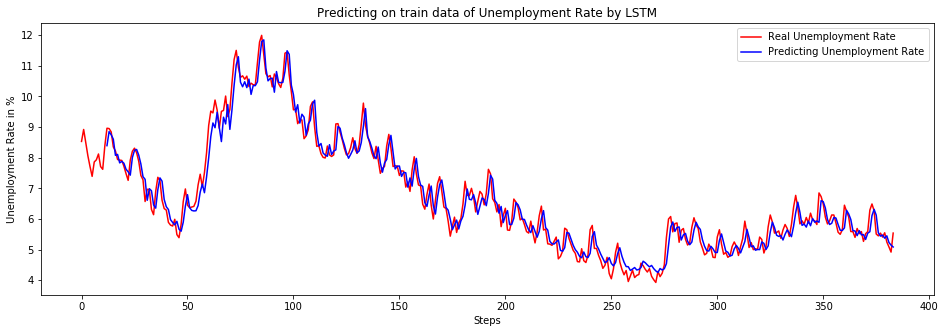

In [24]:
# One-step prediction on train data
optimal_lstm_train_result = optimal_lstm_model.predict(X_train_lstm)
optimal_lstm_train_result = sc_lstm.inverse_transform(optimal_lstm_train_result)

plt.figure(figsize=(16, 5)) 
plt.plot(ts_train_lstm, color='red', label='Real Unemployment Rate')
plt.plot(np.arange(lookback_step, len(ts_train_lstm)),optimal_lstm_train_result, color='blue', label='Predicting Unemployment Rate') 
plt.title('Predicting on train data of Unemployment Rate by LSTM')
plt.xlabel('Steps')
plt.ylabel('Unemployment Rate in %')
plt.legend()

### **Plot graph between test data and forecasting by LSTM model**

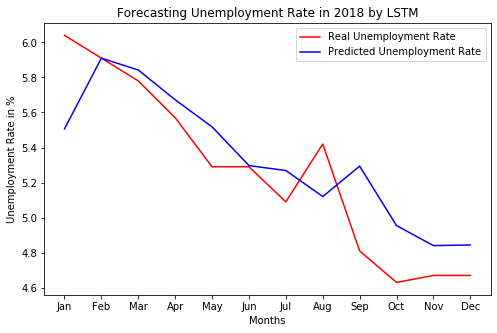

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(ts_test_lstm, color='red',label='Real Unemployment Rate')
plt.plot(optimal_lstm_fcast, color='blue',label='Predicted Unemployment Rate')
plt.title('Forecasting Unemployment Rate in 2018 by LSTM')
plt.xlabel('Months')
plt.ylabel('Unemployment Rate in %')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()
plt.show()

### **Calculate MSE value with optimal hyperparameter**

In [26]:
print("Optimal value of neurons is:", optimal_lstm_neurons)
print("Optimal value of batch size is:", optimal_lstm_batch_size)
print("Optimal value of dropout is:", optimal_lstm_dropout)
print("The lowest MSE value of LSTM model is: {0:.3F}".format(min_mse_lstm))                    

Optimal value of neurons is: 15
Optimal value of batch size is: 6
Optimal value of dropout is: 0.05
The lowest MSE value of LSTM model is: 0.073
